# 07-router-pattern.ipynb
- 멀티 에이전트 패턴
- Supervisor (관리자 agent) 없음
- 시작과 동시에 어떤 어떤 agent 를 사용해야 할 지 판단(1~n개)
- n개의 agent를 병렬(!) 실행
- 각 agent들이 만든 결과를 종합

In [1]:
from dotenv import load_dotenv
load_dotenv()


True

In [2]:
from langchain.chat_models import init_chat_model

model = init_chat_model('gpt-4.1')

c:\Users\user\AppData\Local\Programs\Python\Python314\Lib\site-packages\langchain_core\_api\deprecation.py:25: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


In [3]:
from typing import Annotated, Literal, TypedDict
import operator

# TypedDict -> "딕셔너리"인데, key의 이름과 value의 데이터 형태를 사전 정의하는 용도!

# 하위 에이전트에 전달되는 간단한 state (query)
# {'query': '~~~~~~' }
class AgentInput(TypedDict):
    """하위 agent들의 input 형태"""
    query: str


# 하위 에이전트가 생성한 결과(source, result)
# {'source': 'slack', 'result': 'qwer'}
class AgentOutput(TypedDict):
    """하위 agent들의 output 형태"""
    source: str
    result: str


# 분류
# {'source': 'slack', 'query': 'asdf'}
class Classification(TypedDict):
    """라우팅 결정: 어떤 agent에게 어떤 query를 넘길지"""
    source: Literal['github', 'notion', 'slack'] 
    query: str


# 주요 워크플로 상태를 추적
class RouterState(TypedDict):
    query: str
    classifications: list[Classification]
    results: Annotated[list[AgentOutput], operator.add]
    final_answer: str

위 `RouterState` 가 최종적으로 만들어 내는 데이터 형태
```python
{
    'query': '사용자 질문',
    'classifications': [
        {'source': 'slack', 'query': 'asdf'},
        {'source': 'github', 'query': 'asdf'},
        {'source': 'notion', 'query': 'asdf'}
    ],
    'results': [
        {'source': 'slack', 'result': 'qwer'},
        {'source': 'github', 'result': 'qwer'},
        {'source': 'notion', 'result': 'qwer'}
    ],
    'final_answer': '그래서 ~~~합니다.'
}
```

In [4]:
# Tool 만들기

from langchain.tools import tool


@tool
def search_code(query: str, repo: str = "main") -> str:
    """Search code in GitHub repositories."""
    return f"Found code matching '{query}' in {repo}: authentication middleware in src/auth.py"


@tool
def search_issues(query: str) -> str:
    """Search GitHub issues and pull requests."""
    return f"Found 3 issues matching '{query}': #142 (API auth docs), #89 (OAuth flow), #203 (token refresh)"


@tool
def search_prs(query: str) -> str:
    """Search pull requests for implementation details."""
    return f"PR #156 added JWT authentication, PR #178 updated OAuth scopes"


@tool
def search_notion(query: str) -> str:
    """Search Notion workspace for documentation."""
    return f"Found documentation: 'API Authentication Guide' - covers OAuth2 flow, API keys, and JWT tokens"


@tool
def get_page(page_id: str) -> str:
    """Get a specific Notion page by ID."""
    return f"Page content: Step-by-step authentication setup instructions"


@tool
def search_slack(query: str) -> str:
    """Search Slack messages and threads."""
    return f"Found discussion in #engineering: 'Use Bearer tokens for API auth, see docs for refresh flow'"


@tool
def get_thread(thread_id: str) -> str:
    """Get a specific Slack thread."""
    return f"Thread discusses best practices for API key rotation"

In [5]:
# 각 전문 하위 에이전트 만들기

from langchain.agents import create_agent
from langchain.chat_models import init_chat_model

model = init_chat_model("openai:gpt-4.1")

github_agent = create_agent(
    model,
    tools=[search_code, search_issues, search_prs],
    system_prompt=(
        "You are a GitHub expert. Answer questions about code, "
        "API references, and implementation details by searching "
        "repositories, issues, and pull requests."
    ),
)

notion_agent = create_agent(
    model,
    tools=[search_notion, get_page],
    system_prompt=(
        "You are a Notion expert. Answer questions about internal "
        "processes, policies, and team documentation by searching "
        "the organization's Notion workspace."
    ),
)

slack_agent = create_agent(
    model,
    tools=[search_slack, get_thread],
    system_prompt=(
        "You are a Slack expert. Answer questions by searching "
        "relevant threads and discussions where team members have "
        "shared knowledge and solutions."
    ),
)

In [6]:
# 라우팅(어떤 agent를 호출해야하는지) LLM 만들기
router_model = init_chat_model('gpt-4.1-mini')

# StructuredOutput 을 통해서, 정해진 포맷으로 LLM 결과 받는 노드 만들기
from pydantic import BaseModel, Field


class RouterResult(BaseModel):
    """사용자 질문을 어떤 하위 에이전트에게 보낼지 결정한 결과"""
    classifications: list[Classification] = Field(
        description='실행할 목표 에이전트들과, 물어볼 질문들 목록'
    )

# 질문을 분류하고, 하위 질문 생성
def route_query(state: RouterState) -> dict:
    """사용자 질문을 분류하고, 어떤 에이전트를 호출할지 결정"""
    s_llm = router_model.with_structured_output(RouterResult)

    result = s_llm.invoke([
        {
            "role": "system",
            "content": """Analyze this query and determine which knowledge bases to consult.
For each relevant source, generate a targeted sub-question optimized for that source.

Available sources:
- github: Code, API references, implementation details, issues, pull requests
- notion: Internal documentation, processes, policies, team wikis
- slack: Team discussions, informal knowledge sharing, recent conversations

Return ONLY the sources that are relevant to the query. Each source should have
a targeted sub-question optimized for that specific knowledge domain.

Example for "How do I authenticate API requests?":
- github: "What authentication code exists? Search for auth middleware, JWT handling"
- notion: "What authentication documentation exists? Look for API auth guides"
(slack omitted because it's not relevant for this technical question)"""
        },
        {"role": "user", "content": state["query"]}
    ])

    return {"classifications": result.classifications}

In [7]:
route_query({'query': 'API 인증은 어케함?'})

c:\Users\user\AppData\Local\Programs\Python\Python314\Lib\site-packages\pydantic\main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=RouterResult(classificati... 확인해주세요.'}]), input_type=RouterResult])
  return self.__pydantic_serializer__.to_python(


{'classifications': [{'source': 'github',
   'query': 'API 인증 코드가 어떻게 구현되어 있나요? auth 미들웨어나 JWT 처리와 관련된 코드를 찾아주세요.'},
  {'source': 'notion', 'query': 'API 인증 관련 문서가 있나요? API 인증 가이드나 정책을 확인해주세요.'}]}

In [8]:
from langgraph.types import Send

# 분류된 에이전트를 실제 호출
def route_to_agents(state: RouterState) -> list[Send]:
    """결정된 하위 에이전트 병렬 호출"""
    result = []
    for c in state['classifications']:
        result.append(Send(c['source'], {'query': c['query']}))
    return result


def query_github(state: AgentInput) -> dict:
    """Query the GitHub agent."""
    result = github_agent.invoke({
        "messages": [{"role": "user", "content": state["query"]}]  
    })
    return {"results": [{"source": "github", "result": result["messages"][-1].content}]}


def query_notion(state: AgentInput) -> dict:
    """Query the Notion agent."""
    result = notion_agent.invoke({
        "messages": [{"role": "user", "content": state["query"]}]  
    })
    return {"results": [{"source": "notion", "result": result["messages"][-1].content}]}


def query_slack(state: AgentInput) -> dict:
    """Query the Slack agent."""
    result = slack_agent.invoke({
        "messages": [{"role": "user", "content": state["query"]}]  
    })
    return {"results": [{"source": "slack", "result": result["messages"][-1].content}]}

# 최종 답변 취합
def synthesize_results(state: RouterState) -> dict:
    """Combine results from all agents into a coherent answer."""
    if not state["results"]:
        return {"final_answer": "No results found from any knowledge source."}

    # Format results for synthesis
    formatted = [
        f"**From {r['source'].title()}:**\n{r['result']}"
        for r in state["results"]
    ]

    synthesis_response = router_model.invoke([
        {
            "role": "system",
            "content": f"""Synthesize these search results to answer the original question: "{state['query']}"

- Combine information from multiple sources without redundancy
- Highlight the most relevant and actionable information
- Note any discrepancies between sources
- Keep the response concise and well-organized"""
        },
        {"role": "user", "content": "\n\n".join(formatted)}
    ])

    return {"final_answer": synthesis_response.content}

In [9]:
from langgraph.graph import StateGraph, START, END

workflow = (
    StateGraph(RouterState)
    .add_node("route", route_query)
    .add_node("github", query_github)
    .add_node("notion", query_notion)
    .add_node("slack", query_slack)
    .add_node("synthesize", synthesize_results)
    .add_edge(START, "route")
    .add_conditional_edges("route", route_to_agents, ["github", "notion", "slack"])
    .add_edge("github", "synthesize")
    .add_edge("notion", "synthesize")
    .add_edge("slack", "synthesize")
    .add_edge("synthesize", END)
    .compile()
)

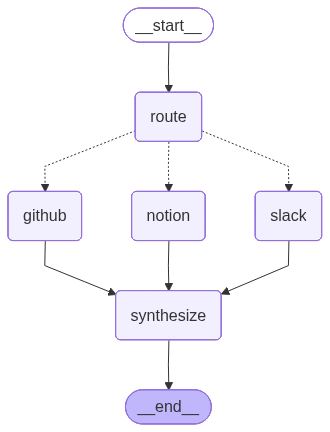

In [10]:
workflow

In [11]:
result = workflow.invoke({
    "query": "How do I authenticate API requests?"
})

print("Original query:", result["query"])
print("\nClassifications:")
for c in result["classifications"]:
    print(f"  {c['source']}: {c['query']}")
print("\n" + "=" * 60 + "\n")
print("Final Answer:")
print(result["final_answer"])

c:\Users\user\AppData\Local\Programs\Python\Python314\Lib\site-packages\pydantic\main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=RouterResult(classificati... for API auth guides'}]), input_type=RouterResult])
  return self.__pydantic_serializer__.to_python(


Original query: How do I authenticate API requests?

Classifications:
  github: What authentication code exists? Search for auth middleware, JWT handling
  notion: What authentication documentation exists? Look for API auth guides


Final Answer:
To authenticate API requests effectively, the common practice involves using tokens—especially JWTs—or API keys, sometimes combined with OAuth2 flows for delegated access.

**Key Approaches Synthesized:**

1. **JWT-Based Authentication (from GitHub `src/auth.py`):**
   - Implement authentication middleware that intercepts API requests to:
     - Extract the Bearer token from the Authorization header.
     - Decode and verify the JWT token's signature and claims.
     - Authorize the request based on the validated token data.
   - Token processing includes encoding tokens during login and decoding on requests to authenticate users.

2. **API Keys and OAuth2 (from Notion "API Authentication Guide"):**
   - For simpler use cases, use API keys pas